# Image Captioning

In [1]:
# Code Formatting Extension
%load_ext nb_black

<IPython.core.display.Javascript object>

# IMPORTS

In [2]:
import string
import datetime as dt
import numpy as np
from pickle import load, dump
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from IPython.display import display, Image
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

# Utils

In [5]:
import tensorflow as tf
print(tf.__version__)

2.6.0-rc1


<IPython.core.display.Javascript object>

In [3]:
# Path to various directories
project_root_path = "../"
dataset_root_path = project_root_path + "Dataset/"
models_root_path = project_root_path + "Models/"
variables_root_path = project_root_path + "Variables/"

<IPython.core.display.Javascript object>

In [4]:
# Function to read data
def read_content(filepath, encode = None):
    lines = []
    with open(filepath, encoding = encode) as file:
        content = file.read()
        lines = content.split("\n")
    return lines[:-1]   # Removing last blank line

# Function to dump data to .pkl file at filepath
def dumpData(filepath, data):
    with open(filepath, "wb") as encoded_pickle:
        dump(data, encoded_pickle)

# Function to load data from .pkl file at filepath
def loadData(filepath):
    with open(filepath, "rb") as encoded_pickle:
        return load(encoded_pickle)

<IPython.core.display.Javascript object>

# EXTRACTING TEXT DATA AND PREPROCESSING

In [5]:
# STEP: EXTRACTING DATA
filepath = dataset_root_path + "Flickr8k_text/Flickr8k.token.txt"
lines = read_content(filepath)

<IPython.core.display.Javascript object>

In [6]:
# STEP: SAVING DATA IN A DICTIONARY FOR TIME EFFICIENCY PURPOSES
def make_dict(text):
    # Dictionary with key as the image id
    img_cpt_dict = dict()

    for line in text:   # Each line format <image_id>.jpg#<num>\t<image_caption>
        [img, img_caption] = line.split("\t")
        img_id = img.split(".")[0]
        if (img_id not in img_cpt_dict.keys()):
            img_cpt_dict[img_id] = list()
        img_cpt_dict[img_id].append(img_caption)
    return img_cpt_dict

img_cpt_dict = make_dict(lines)

print("Number of images in Dataset:", len(img_cpt_dict))

Number of images in Dataset: 8092


<IPython.core.display.Javascript object>

In [7]:
# STEP: PREPROCESSING
# Lowercasing & Removing punctuations and special tokens like #,$,@
def preprocess_captions(dct):
    # prepare translation table for removing punctuation
    table = str.maketrans("", "", string.punctuation)
    for captions in dct.values():
        for i in range(len(captions)):
            caption = captions[i]
            # tokenize
            words = caption.split()
            # convert to lower case
            words = [word.lower() for word in words]
            # remove punctuation from each token
            words = [word.translate(table) for word in words]
            # remove hanging 's' and 'a'
            words = [word for word in words if len(word) > 1]
            # remove tokens with numbers in them
            words = [word for word in words if word.isalpha()]
            # store as string
            captions[i] = " ".join(words)

preprocess_captions(img_cpt_dict)

dumpData(variables_root_path + "img_cpt_dict.pickle", img_cpt_dict)

<IPython.core.display.Javascript object>

# LOADING TRAINING SET

In [8]:
# STEP: EXTRACTING DATA
filepath = dataset_root_path + "Flickr8k_text/Flickr_8k.trainImages.txt"
lines = read_content(filepath)

<IPython.core.display.Javascript object>

In [9]:
# STEP: SAVING DATA IN A LIST
def make_list(text):
    img_list = list()
    for line in text:
        [img_title, ext] = line.split(".")
        img_list.append(img_title)
    return img_list

train = make_list(lines)

<IPython.core.display.Javascript object>

In [10]:
# STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
def start_end_token(dataset):
    new_dataset = dict()
    max_caption_length = 0
    for img_title, captions in img_cpt_dict.items():
        if (img_title in dataset and (img_title not in new_dataset.keys())):
            new_dataset[img_title] = list()
            for caption in captions:
                # wrap caption in tokens
                new_caption = "startseq " + caption + " endseq"
                new_dataset[img_title].append(new_caption)
                max_caption_length = max(max_caption_length, len(new_caption.split()))
    return (new_dataset, max_caption_length)

train_dataset, max_caption_length = start_end_token(train)

print("Length of Train Dataset:", len(train_dataset))
print("Maximum Caption Length:", max_caption_length)

dumpData(variables_root_path + "train_dataset.pickle", train_dataset)
dumpData(variables_root_path + "max_caption_length.pickle", max_caption_length)

Length of Train Dataset: 6000
Maximum Caption Length: 34


<IPython.core.display.Javascript object>

# LOADING CROSS VALIDATION(OR DEVELOPMENT) SET

In [11]:
# STEP: EXTRACTING DATA
filepath = dataset_root_path + "Flickr8k_text/Flickr_8k.devImages.txt"
lines = read_content(filepath)

<IPython.core.display.Javascript object>

In [12]:
# STEP: SAVING DATA IN A LIST
dev = make_list(lines)

<IPython.core.display.Javascript object>

In [13]:
# STEP: SAVING IMAGE-CAPTIONS IN DEV DATASET
dev_dataset, stuff = start_end_token(dev)

print("Length of Dev Dataset:", len(dev_dataset))

dumpData(variables_root_path + "dev_dataset.pickle", dev_dataset)

Length of Dev Dataset: 1000


<IPython.core.display.Javascript object>

# LOADING TESTING SET

In [14]:
# STEP: EXTRACTING DATA
filepath = dataset_root_path + "Flickr8k_text/Flickr_8k.testImages.txt"
lines = read_content(filepath)

<IPython.core.display.Javascript object>

In [15]:
# STEP: SAVING DATA IN A LIST
test = make_list(lines)

<IPython.core.display.Javascript object>

In [16]:
# STEP: SAVING IMAGE-CAPTIONS IN TESt DATASET
test_dataset, stuff = start_end_token(test)

print("Length of Test Dataset:", len(test_dataset))

dumpData(variables_root_path + "test_dataset.pickle", test_dataset)

Length of Test Dataset: 1000


<IPython.core.display.Javascript object>

# CONSTRUCTING VOCABULARY FROM CAPTIONS

In [17]:
def create_vocabulary(dct):
    vocab = set()
    for captions in dct.values():
        for caption in captions:
            for word in caption.split():
                vocab.add(word)
    return vocab

vocab = create_vocabulary(img_cpt_dict)

print("Number of different words in vocabulary:", len(vocab))

dumpData(variables_root_path + "vocab.pickle", vocab)

Number of different words in vocabulary: 8763


<IPython.core.display.Javascript object>

# CONSTRUCTING MOST PROBABLE VOCABULARY FROM ALL TRAIN WORDS

In [18]:
def most_probable_vocab(dct, threshold = 8):
    probable_vocab_counts = dict()
    for captions in dct.values():
        for caption in captions:
            for word in caption.split():
                if (word not in probable_vocab_counts.keys()):
                    probable_vocab_counts[word] = 0
                else:
                    probable_vocab_counts[word] += 1
  
    return {word for word in probable_vocab_counts if probable_vocab_counts[word] >= threshold}

most_probable_vocabulary = most_probable_vocab(train_dataset)
vocabulary_size = len(most_probable_vocabulary)

print("Most Probable Vocabulary Size:", vocabulary_size)

dumpData(variables_root_path + "most_probable_vocabulary.pickle", most_probable_vocabulary)
dumpData(variables_root_path + "vocabulary_size.pickle", vocabulary_size)

Most Probable Vocabulary Size: 1762


<IPython.core.display.Javascript object>

### TO GET INPUT VECTOR X FROM IMAGES WE USE TRANSFER LEARNING THROUGH ResNet152V2 MODEL TRAINED ON 1000 DIFFERENT CLASSES OF IMAGES

In [19]:
model = ResNet152V2(weights = "imagenet")
resnet_model = Model(model.input, model.layers[-2].output)

resnet_model.save(models_root_path + "resnet_model")

INFO:tensorflow:Assets written to: ./Models/resnet_model\assets


C:\Users\singl\.virtualenvs\Image_Captioning-is0OUI90\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


<IPython.core.display.Javascript object>

In [22]:
# EXTRACT FEATURES FROM EACH PHOTO IN THE DATASET AND ENCODE THEM AS A DICTIONARY
def encode_set_images(dataset):
    encoded_dataset_images = {}
    start = dt.datetime.now()
    i = 0
    for img_title in dataset.keys():
        # load an image from file
        img_path = dataset_root_path + "Flicker8k_Dataset/" + img_title + ".jpg"
        img = image.load_img(img_path, target_size = (224, 224))
        # convert the image pixels to a numpy array
        x = image.img_to_array(img)
        # prepare the image for the ResNet model
        x = np.expand_dims(x, axis = 0)
        x = preprocess_input(x)
        # get features
        feature_vec = resnet_model.predict(x)
        # reshape data for the model
        feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
        # store feature
        encoded_dataset_images[img_title] = feature_vec
        present = dt.datetime.now()
        if ((i/500).is_integer()):
            print("{}th ITERATION".format(i))
            print("TIME SO FAR: {}s".format((present - start).total_seconds()))
        i += 1
    end = dt.datetime.now()
    print("TIME TAKEN TO ENCODE TRAIN IMAGES INTO 2048 LENGTH FEATURE VECTOR: {}s".format((end - start).total_seconds()))
    return encoded_dataset_images


<IPython.core.display.Javascript object>

In [ ]:
# UNCOMMENT BELOW CODE AND EXECUTE IT ONLY IF YOU DON'T HAVE .pkl FILES TO GENERATE NEW
# encoded_train_images = encode_set_images(train_dataset)

In [ ]:
# UNCOMMENT BELOW CODE AND EXECUTE IT ONLY IF YOU DON'T HAVE .pkl FILES TO GENERATE NEW
# encoded_dev_images = encode_set_images(dev_dataset)

In [ ]:
# UNCOMMENT BELOW CODE AND EXECUTE IT ONLY IF YOU DON'T HAVE .pkl FILES TO GENERATE NEW
# encoded_test_images = encode_set_images(test_dataset)

In [26]:
# WRITING ENCODED TRAIN IMAGES, ENCODED DEV IMAGES AND ENCODED TEST IMAGES TO PICKLE FILES
# UNCOMMENT BELOW CODE AND EXECUTE IT ONLY IF YOU DON'T HAVE .pickle FILES TO GENERATE NEW

# filepath = variables_root_path + "encoded_train_images_resnet.pickle"
# dumpData(filepath, encoded_train_images)

# filepath = variables_root_path + "encoded_dev_images_resnet.pickle"
# dumpData(filepath, encoded_dev_images)

# filepath = variables_root_path + "encoded_test_images_resnet.pickle"
# dumpData(filepath, encoded_test_images)

<IPython.core.display.Javascript object>

In [27]:
# READING ENCODED TRAIN IMAGES, ENCODED DEV IMAGES AND ENCODED TEST IMAGES FROM PKL FILES

filepath = variables_root_path + "encoded_train_images_resnet.pickle"
encoded_train_images = loadData(filepath)

filepath = variables_root_path + "encoded_dev_images_resnet.pickle"
encoded_dev_images = loadData(filepath)

filepath = variables_root_path + "encoded_test_images_resnet.pickle"
encoded_test_images = loadData(filepath)

<IPython.core.display.Javascript object>

In [28]:
# USEFUL DICTIONARIES
index_to_word = {}
word_to_index = {}
for index, word in enumerate(most_probable_vocabulary):
    index_to_word[index] = word
    word_to_index[word] = index

dumpData(variables_root_path + "index_to_word.pickle", index_to_word)
dumpData(variables_root_path + "word_to_index.pickle", word_to_index)

<IPython.core.display.Javascript object>

In [30]:
# WORD EMBEDDINGS, MAPPING EVERY WORD OF OUR MOST PROBABALE VOCABULARY TO 200 DIMENSION VECTOR, FOR THAT WE WILL BE USING GLOVE
embeddings = {}
filepath = dataset_root_path + "glove.6B/glove.6B.200d.txt"
lines = read_content(filepath, encode = "utf8")
for line in lines:
    word_and_vector = line.split()
    word = word_and_vector[0]
    vector = word_and_vector[1:]
    vector = np.asarray(vector, dtype = "float32")
    embeddings[word] = vector


# MAPPING MOST PROBABLE VOCABULARY TO VECTOR BY CREATING A DENSE MATRIX WITH ROW AS WORD AND COLUMNS ARE 200 DIMENSIONS OF VECTOR
embedding_dim = 200
embeddings_matrix = np.zeros((vocabulary_size + 1, embedding_dim))
for word, index in word_to_index.items():
    vector = embeddings.get(word)
    if (vector is not None):
        # words not found in embedding index will be all-zeros.
        embeddings_matrix[index] = vector
# NOTE: DIMENSION OF EMBEDDINGS MATRIX IS (MOST PROBABLE VOCABULARY X 200)
# NOTE: 1ST ROW OF EMBEDDINGS MATRIX IS ALL ZEROS

dumpData(variables_root_path + "embeddings_matrix.pickle", embeddings_matrix)
dumpData(variables_root_path + "embedding_dim.pickle", embedding_dim)

<IPython.core.display.Javascript object>

# Part 2

In [5]:
# Loading Variables
# IMPORTANT: VARIABLES USED TO TRAIN A PARTICULAR INSTANCE OF MODEL SHOULD ALSO BE PRESERVED WHEN LOADING THAT SAVED MODEL AGAIN ELSE IT WON'T WORK
img_cpt_dict = loadData(variables_root_path + "img_cpt_dict.pickle")
train_dataset = loadData(variables_root_path + "train_dataset.pickle")
max_caption_length = loadData(variables_root_path + "max_caption_length.pickle")
dev_dataset = loadData(variables_root_path + "dev_dataset.pickle")
test_dataset = loadData(variables_root_path + "test_dataset.pickle")
vocab = loadData(variables_root_path + "vocab.pickle")
most_probable_vocabulary = loadData(variables_root_path + "most_probable_vocabulary.pickle")
vocabulary_size = loadData(variables_root_path + "vocabulary_size.pickle")

resnet_model = load_model(models_root_path + "resnet_model")

encoded_train_images = loadData(variables_root_path + "encoded_train_images_resnet.pickle")
encoded_dev_images = loadData(variables_root_path + "encoded_dev_images_resnet.pickle")
encoded_test_images = loadData(variables_root_path + "encoded_test_images_resnet.pickle")

index_to_word = loadData(variables_root_path + "index_to_word.pickle")
word_to_index = loadData(variables_root_path + "word_to_index.pickle")
embeddings_matrix = loadData(variables_root_path + "embeddings_matrix.pickle")
embedding_dim = loadData(variables_root_path + "embedding_dim.pickle")

<IPython.core.display.Javascript object>

In [8]:
# data generator, intended to be used in a call to model.fit_generator()
# create sequences of images, input sequences and output words for an image
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            photo = photos[key]
            # walk through each description for the image
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(" ") if word in wordtoix]
                # split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocabulary_size + 1)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if (n == num_photos_per_batch):
                yield ([np.array(X1), np.array(X2)], np.array(y))
                # retrieve the photo feature
                X1, X2, y = list(), list(), list()
                n = 0


<IPython.core.display.Javascript object>

In [9]:
# DEFINING THE LAYERS OF THE MODEL
def model_definition(vocab_size, max_length, embedding_dimension):
    # feature extractor model
    inputs1 = Input(shape = (2048,))
    image_feature = Dropout(0.5)(inputs1)
    image_feature = Dense(256, activation = "relu")(image_feature)

    # sequence model
    inputs2 = Input(shape = (max_length,))
    language_feature = Embedding(vocab_size + 1, embedding_dimension, mask_zero = True)(inputs2)
    language_feature = Dropout(0.5)(language_feature)
    language_feature = LSTM(256)(language_feature)

    # decoder model
    output = add([image_feature, language_feature])
    output = Dense(256, activation = "relu")(output)
    output = Dense(vocab_size + 1, activation = "softmax")(output)

    # tie it together [image, seq] [word]
    model = Model(inputs = [inputs1, inputs2], outputs = output)

    # summarize model
    print(model.summary())
    return model

language_model = model_definition(vocabulary_size, max_caption_length, embedding_dim)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      352600      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [10]:
# SETTING ADDITIONAL PROPERTIES FOR EMBEDDING LAYER I.E. NO TRAINING ON EMBEDDINGS LAYER
language_model.layers[2].set_weights([embeddings_matrix])
language_model.layers[2].trainable = False

# COMPILING THE MODEL
language_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

<IPython.core.display.Javascript object>

In [12]:
# HYPERPARAMETERS OF TRAINING SESSION 1
# NOTE: DEFAULT LEARNING RATE OF KERAS MODEL IS 0.001
epochs = 20
batch_size = 3
steps = len(train_dataset) // batch_size
# NOTE: SIZE OF TRAIN DATASET IS 6000

<IPython.core.display.Javascript object>

In [13]:
# TRAINING SESSION 1
loss1, accuracy1 = list(), list()

for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = language_model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    loss1.append(hist.history["loss"])
    accuracy1.append(hist.history["accuracy"])

language_model.save(models_root_path + "language_model_0")

2000/2000 [==============================] - 439s 219ms/step - loss: 2.5700 - accuracy: 0.3738


INFO:tensorflow:Assets written to: ./Models/language_model_0\assets


INFO:tensorflow:Assets written to: ./Models/language_model_0\assets
C:\Users\singl\.virtualenvs\Image_Captioning-is0OUI90\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


<IPython.core.display.Javascript object>

In [14]:
# HYPERPARAMETERS OF TRAINING SESSION 2
# NOTE: LEARNING RATE IS CHANGED TO 0.0005
K.set_value(language_model.optimizer.lr, 0.0005)
epochs = 5
batch_size = 4
steps = len(train_dataset) // batch_size
# NOTE: SIZE OF TRAIN DATASET IS 6000

<IPython.core.display.Javascript object>

In [15]:
# TRAINING SESSION 2
loss2, accuracy2 = list(), list()

for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = language_model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    loss2.append(hist.history["loss"])
    accuracy2.append(hist.history["accuracy"])

language_model.save(models_root_path + "language_model_1")

1500/1500 [==============================] - 509s 340ms/step - loss: 2.4011 - accuracy: 0.3999


INFO:tensorflow:Assets written to: ./Models/language_model_1\assets


INFO:tensorflow:Assets written to: ./Models/language_model_1\assets
C:\Users\singl\.virtualenvs\Image_Captioning-is0OUI90\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


<IPython.core.display.Javascript object>

In [16]:
# TWEAKED THE PARAMETERS(LEARNING RATE DECAY)
# HYPERPARAMETERS OF TRAINING SESSION 3
# NOTE: LEARNING RATE IS CHANGED TO 0.0003
K.set_value(language_model.optimizer.lr, 0.0003)
epochs = 5
batch_size = 6
steps = len(train_dataset) // batch_size
# NOTE: SIZE OF TRAIN DATASET IS 6000

<IPython.core.display.Javascript object>

In [17]:
# TRAINING SESSION 3
loss3, accuracy3 = list(), list()

for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = language_model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    loss3.append(hist.history["loss"])
    accuracy3.append(hist.history["accuracy"])

language_model.save(models_root_path + "language_model_2")

1000/1000 [==============================] - 475s 475ms/step - loss: 2.3376 - accuracy: 0.4110


INFO:tensorflow:Assets written to: ./Models/language_model_2\assets


INFO:tensorflow:Assets written to: ./Models/language_model_2\assets
C:\Users\singl\.virtualenvs\Image_Captioning-is0OUI90\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


<IPython.core.display.Javascript object>

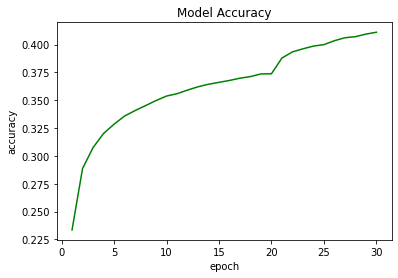

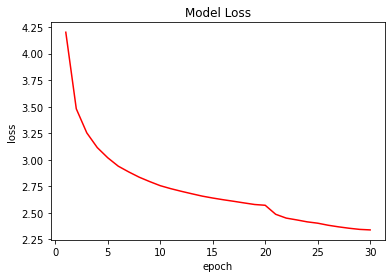

<IPython.core.display.Javascript object>

In [44]:
# Function to flatten the array
def flattenArr(arr):
    return [el[0] for el in arr]

lossArr = [*flattenArr(loss1), *flattenArr(loss2), *flattenArr(loss3)]
accArr = [*flattenArr(accuracy1), *flattenArr(accuracy2), *flattenArr(accuracy3)]
epochArr = [i for i in range(1, len(lossArr) + 1)]

# summarize history for accuracy
plt.plot(epochArr, accArr, "g")
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

# summarize history for loss
plt.plot(epochArr, lossArr, "r")
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [6]:
# LOADING PRE-TRAINED MODEL
loaded_language_model = load_model(models_root_path + "language_model_2")

print(loaded_language_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      352600      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [7]:
def predict(feature_vec):
    partial_caption = "startseq"
    for i in range(max_caption_length):
        # integer encode input sequence
        seq = [word_to_index[word] for word in partial_caption.split() if word in word_to_index]
        # pad input
        seq = pad_sequences([seq], maxlen = max_caption_length)
        # predict next word
        model_softMax_output = loaded_language_model.predict([feature_vec, seq], verbose = 0)
        # convert probability to integer
        word_index = np.argmax(model_softMax_output)
        # map integer to word
        word = index_to_word[word_index]
        partial_caption += " " + word
        if (word == "endseq"):
            break
    final_caption = partial_caption.split()[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

<IPython.core.display.Javascript object>

ResNet Model
3710520638_866d542a80


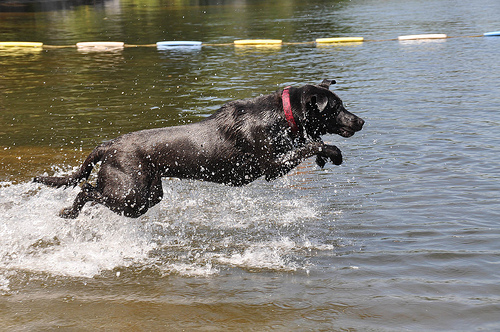

Prediction: black dog is running through the water

Actual Description: black dog jumping into lake
Actual Description: black dog with red collar is jumping in the water
Actual Description: black dog with red collar is jumping out of the water
Actual Description: black dog with red collar splashing in water
Actual Description: the black dog with red collar is jumping through the water


<IPython.core.display.Javascript object>

In [49]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("ResNet Model")
print(key)

feature_vec = encoded_dev_images[key].reshape((1, 2048))

display(Image(filename = dataset_root_path + "Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()

for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

In [56]:
# PERFORMANCE ON TRAIN DATASET, DEV DATASET, TEST DATASET
batch_size = 3
steps = len(train_dataset) // batch_size
train_generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
train_performance = loaded_language_model.evaluate(train_generator, steps = steps, verbose = 0)

batch_size = 3
steps = len(dev_dataset) // batch_size
dev_generator = data_generator(dev_dataset, encoded_dev_images, word_to_index, max_caption_length, batch_size)
dev_performance = loaded_language_model.evaluate(dev_generator, steps = steps, verbose = 0)

batch_size = 3
steps = len(test_dataset) // batch_size
test_generator = data_generator(test_dataset, encoded_test_images, word_to_index, max_caption_length, batch_size)
test_performance = loaded_language_model.evaluate(test_generator, steps = steps, verbose = 0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance[0]))
print("ACCURACY ON TRAIN DATASET: {}".format(train_performance[1]))

print("LOSS ON DEV DATASET: {}".format(dev_performance[0]))
print("ACCURACY ON DEV DATASET: {}".format(dev_performance[1]))

print("LOSS ON TEST DATASET: {}".format(test_performance[0]))
print("ACCURACY ON TEST DATASET: {}".format(test_performance[1]))

LOSS ON TRAIN DATASET: 2.1425817012786865
ACCURACY ON TRAIN DATASET: 0.44499143958091736
LOSS ON DEV DATASET: 3.849219799041748
ACCURACY ON DEV DATASET: 0.32388588786125183
LOSS ON TEST DATASET: 3.7788126468658447
ACCURACY ON TEST DATASET: 0.32825222611427307


<IPython.core.display.Javascript object>

In [57]:
# GENERATING BLEU SCORES
def generate_bleu_scores(dataset, encoded_images):
    actual, predicted = list(), list()
    for key, desc_list in dataset.items():
        # store actual
        references = [desc.split() for desc in desc_list]
        actual.append(references)
        # generate caption
        feature_vec = encoded_images[key].reshape((1, 2048))
        prediction = predict(feature_vec)
        predicted.append(prediction.split())

    # calculate BLEU score
    print("BLEU-1: {}".format(corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0))))
    print("BLEU-2: {}".format(corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0, 0))))
    print("BLEU-3: {}".format(corpus_bleu(actual, predicted, weights = (0.3, 0.3, 0.3, 0))))
    print("BLEU-4: {}".format(corpus_bleu(actual, predicted, weights = (0.25, 0.25, 0.25, 0.25))))

print("BLEU SCORES FOR TEST DATASET")
generate_bleu_scores(test_dataset, encoded_test_images)
print()
print("BLEU SCORES FOR DEV DATASET")
generate_bleu_scores(dev_dataset, encoded_dev_images)

BLEU SCORES FOR TEST DATASET
BLEU-1: 0.4134143880407469
BLEU-2: 0.241927935595684
BLEU-3: 0.171063267544442
BLEU-4: 0.08284407743235575

BLEU SCORES FOR DEV DATASET
BLEU-1: 0.42148922627188107
BLEU-2: 0.24852675796719415
BLEU-3: 0.1792469512848038
BLEU-4: 0.0871738928405672


<IPython.core.display.Javascript object>

ResNet Model
3227148358_f152303584


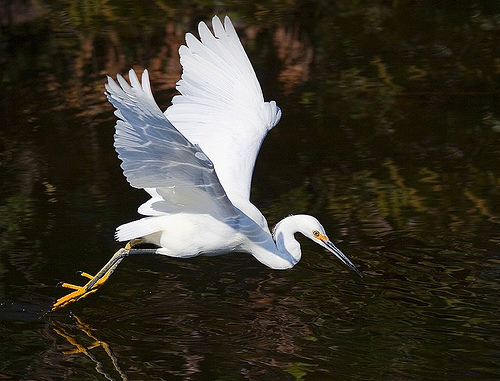

Prediction: bird descending water

Actual Description: bird flies above the water
Actual Description: heron is flying through the air near foliage
Actual Description: large white bird flying over water
Actual Description: large white bird swoops over water
Actual Description: white bird with yellow feet is flying over water

ResNet Model
2208067635_39a03834ca


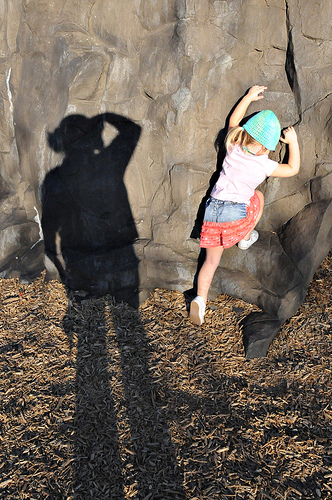

Prediction: two girls are playing in the leaves

Actual Description: girl is climbing rock while someone is filming her
Actual Description: little girl is climbing up rock as her mom shadow is casting over the rock
Actual Description: small child climbs large rock while someone casting shadow takes her picture
Actual Description: young girl is rock climbing
Actual Description: the long black shadow casts image on the rock while the young girl climbs the rock

ResNet Model
150387174_24825cf871


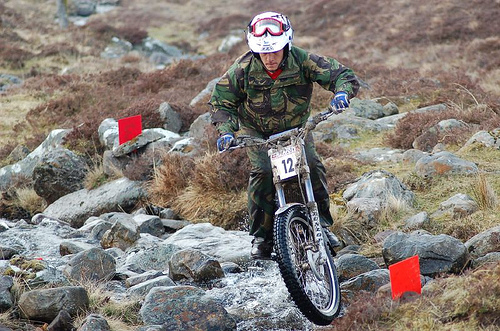

Prediction: man in helmet riding bike down the road

Actual Description: man dressed in camouflage riding motorbike
Actual Description: man is going between two red flag markers on dirt bike
Actual Description: man is riding dirt bike over some rocks
Actual Description: man wearing camouflage steers motorcycle across some stones
Actual Description: the man waeribng helmet is riding dirt bike over rocks

ResNet Model
143688283_a96ded20f1


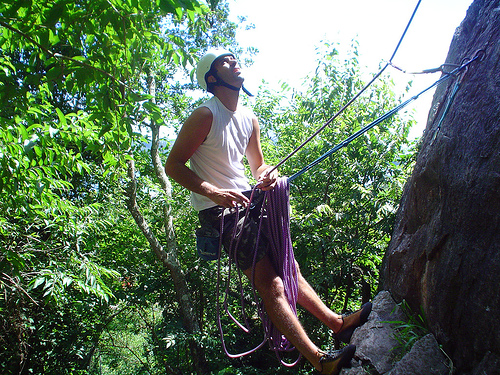

Prediction: boy in red shirt is climbing rock wall

Actual Description: man in harness climbing rock wall
Actual Description: man with white shirt and helmet is climbing mountain
Actual Description: man in white shirt and helmet is using climbing equipment
Actual Description: young man wearing white helmet climbing up rock wall
Actual Description: man rock climbing looking up the rock

ResNet Model
3670907052_c827593564


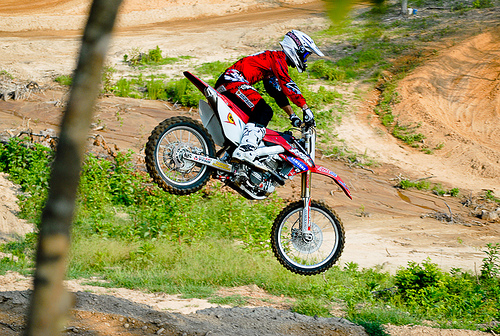

Prediction: man riding bicycle down dirt hill

Actual Description: bmx rider in red and black outfit is jumping on his motorcycle
Actual Description: dirt biker flies through the air
Actual Description: guy in red on bike in midair
Actual Description: man in red outfit jumps his motocross bike down the hill
Actual Description: someone in red on bike is moving in midair

ResNet Model
3497224764_6e17544e0d


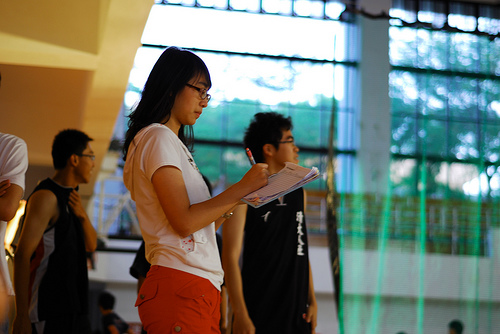

Prediction: two young girls are standing in front of christmas tree single

Actual Description: woman in red shorts is writing on tablet
Actual Description: woman wearing white shirt and red pants is writing something down at museum
Actual Description: woman writing while standing by men
Actual Description: the lady is taking notes
Actual Description: the lady is wearing white shirt with red pants and writing on note pad

ResNet Model
2340206885_58754a799a


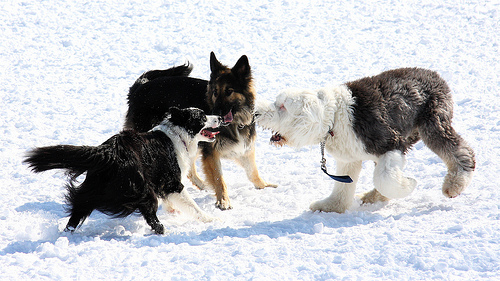

Prediction: two dogs are playing in the snow

Actual Description: group of dogs look at each other while standing in the snow
Actual Description: three dogs come face to face with each other in snowy field
Actual Description: three dogs in the snow
Actual Description: three dogs meet in the snow
Actual Description: three dogs playing in the snow

ResNet Model
2529116152_4331dabf50


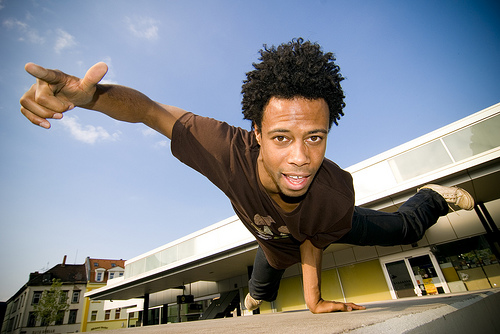

Prediction: boy in red shirt is jumping on the bed

Actual Description: darked skinned male is standing on one palm in front of yellow building
Actual Description: man break dances
Actual Description: man holding himself with one arm front of store
Actual Description: young man jumps on table
Actual Description: this black man appears to be break dancing on the pavement

ResNet Model
2309860995_c2e2a0feeb


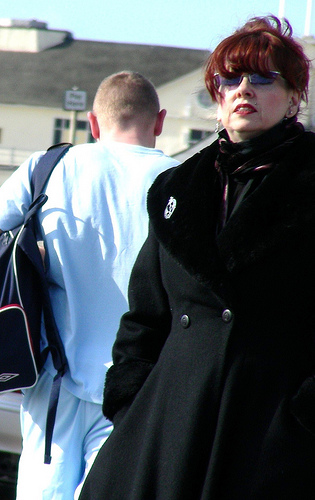

Prediction: man in black shirt and hat is sitting on the street

Actual Description: woman in black overcoat and red hair with man in white walking behind her
Actual Description: woman wearing black coat and sunglasses is standing in front of man walking away with backpack
Actual Description: woman wears sunglasses and black coat as she walks
Actual Description: there is woman in black jacket and sunglasses and man in white shirt with his back turned
Actual Description: the woman in the dark coat is facing the camera while the man in the blue shirt faces away

ResNet Model
3568197730_a071d7595b


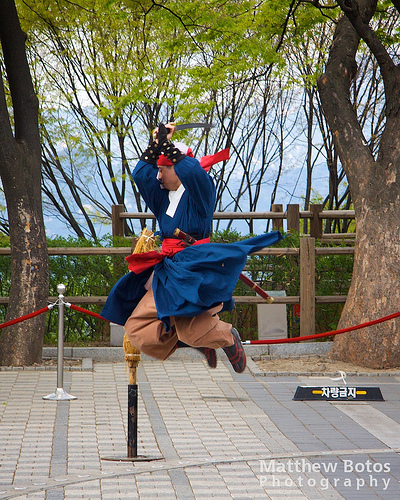

Prediction: boy in red shirt is jumping off of playground equipment

Actual Description: japanese swordsman jumps into the air
Actual Description: man in blue outfit is swinging sword in the air
Actual Description: an actor dressed as pirate performs in an outdoor park
Actual Description: person wearing blue robe is in the air holding sword
Actual Description: man in martial artsstyle costume jumping in midair



<IPython.core.display.Javascript object>

In [52]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM TEST DATASET
keys = np.random.choice(list(test_dataset.keys()), 10)
for key in keys:
    print("ResNet Model")
    print(key)

    feature_vec = encoded_test_images[key].reshape((1, 2048))

    display(Image(filename = dataset_root_path + "Flicker8k_Dataset/" + key + ".jpg"))
    print("Prediction: {}".format(predict(feature_vec)))
    print()

    for caption in test_dataset[key]:
        caption = " ".join(caption.split()[1:-1])
        print("Actual Description: {}".format(caption))
    print()


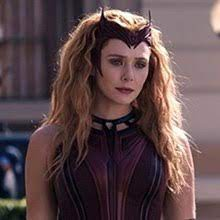

Prediction: woman with curly hair wearing red shirt and hoop



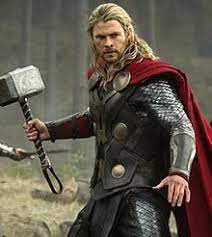

Prediction: man in black shirt and cap is holding up cup



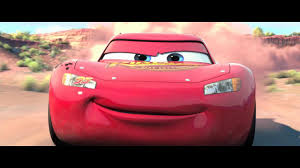

Prediction: two girls are sitting in red car



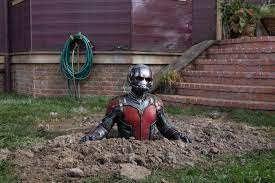

Prediction: man in red shirt and jeans is sitting on bench with camping



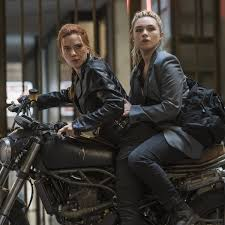

Prediction: man in black jacket and hat is sitting on bench



<IPython.core.display.Javascript object>

In [8]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES INPUT FROM LOCAL MACHINE
def image_to_feature_vec(image_path):
    img = image.load_img(image_path, target_size = (224, 224))
    # convert the image pixels to a numpy array
    x = image.img_to_array(img)
    # prepare the image for the ResNet model
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    # get features
    feature_vec = resnet_model.predict(x)
    # reshape data for the model
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    return feature_vec.reshape((1, 2048))

for i in range(1, 6):
    image_path = project_root_path + "TestingImages/" + str(i) + ".jpg"

    feature_vec = image_to_feature_vec(image_path)

    display(Image(filename = image_path))
    print("Prediction: {}".format(predict(feature_vec)))
    print()